#ResNetVAE

Для генерации используется VAE архитектура, где вектора средних и вектор дисперсий генерируется с использованием convolutions в Encoder и Decoder блоках.

Для реализации сверточных слоёв использовалась ResNet подобная архитектура. То есть архитектура, где каждый следующий слой свертки связан с предыдущим, путём остаточных соединений (residual connection). В нашем случае она выглядела примерно следующий образом (Рисунок 1): 


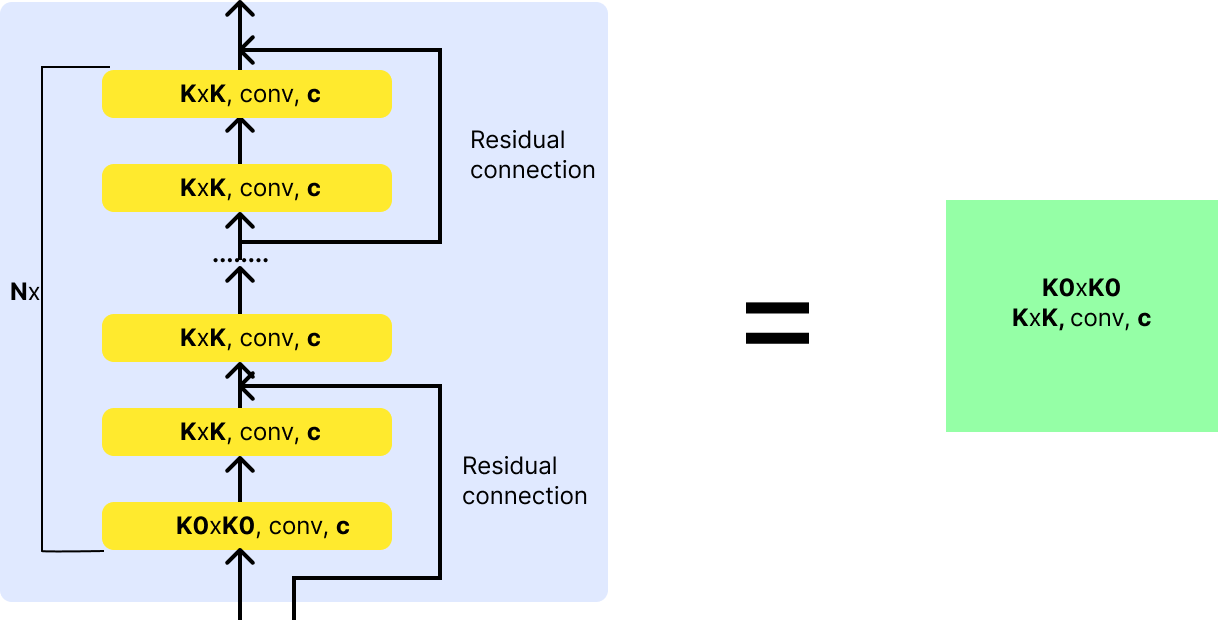
(Рисунок 1)

где **N** количество такой сверточных слоёв, **K** - размер ядра свертки, а **K0** - размер ядра первой свертки, а **c** - количество каналов, в которые нужно отобразить.

Сама же желтая свертка состоит также из нескольких блоков, и имеет следующую последовательность элементов:
- Convolution;
- BatchNorm;
- ReLU.

Из изображения становится понятно, что размер ядра и количество выходных каналов остаётся неизменным на протяжении всего блока. В нашем случае эта картинка показывает, что из себя представляет класс **ConvBlock**. При этом, из изображения следует, что через каждую пару таких сверток происходит соединение между ними. То есть выход $i-$го блока складывается с выходом $(i+2)-$го блока. При этом происходит обычное поэлементное сложение. 
Но, как можно заметить, вход в **ConvBlock** имеет 2 соединения и это не с проста, далее раскроем отличия.

Далее, из таких нескольких **ConvBlock** строится **ResNet**-подобная архитектура (см. Рисунок 2. ResNetBlock), в нашем случае, например:
- ConvBlock с **N** = 2, **K** = 3, **c** = 32;
- ConvBlock с **N** = 2, **K** = 3, **c** = 64;
- ConvBlock с **N** = 4, **K** = 3, **c** = 128;
- ConvBlock с **N** = 4, **K** = 3, **c** = 256.


Сама ResNet-подобная архитектура (см. Рисунок 2. ResNetBlock) состоит не только из этих сверточных блоков, но еще из блоков, соединяющих два близких **ConvBlock**. Для чего это нужно?
Пусть $X_k$ это выход с $k-$го **ConvBlock**, который должен поступить в $k+1-$го блока. Проблема заключается в том, что $X_k \in \mathbb{R}^{c_k × h_k × w_k}$, а $X_{k+1} \in \mathbb{R}^{c_{k+1} × h_{k+1} × w_{k+1}}$. Для этого нужно отобразить $X_k$ в пространство $\mathbb{R}^{c_{k+1} × h_{k+1} × w_{k+1}}$, этим то и занимается **conv1x1**, она просто строит следующее отображение $ \phi(X_k): \mathbb{R}^{c_k × h_k × w_k} \rightarrow \mathbb{R}^{c_{k+1} × h_{k+1} × w_{k+1}}$. В этом то и заключается два разных входа в **ConvBlock**:
1. Первый вход в **ConvBlock** (нумерация начинается с лева) подается $X_k$;
2. Во второй вход подаётся $X_k^{'} = \phi(X_k)$.

При этом отображение $\phi$, как несложно понять, также обладает параметрами, которые изменяются по мере обучения.

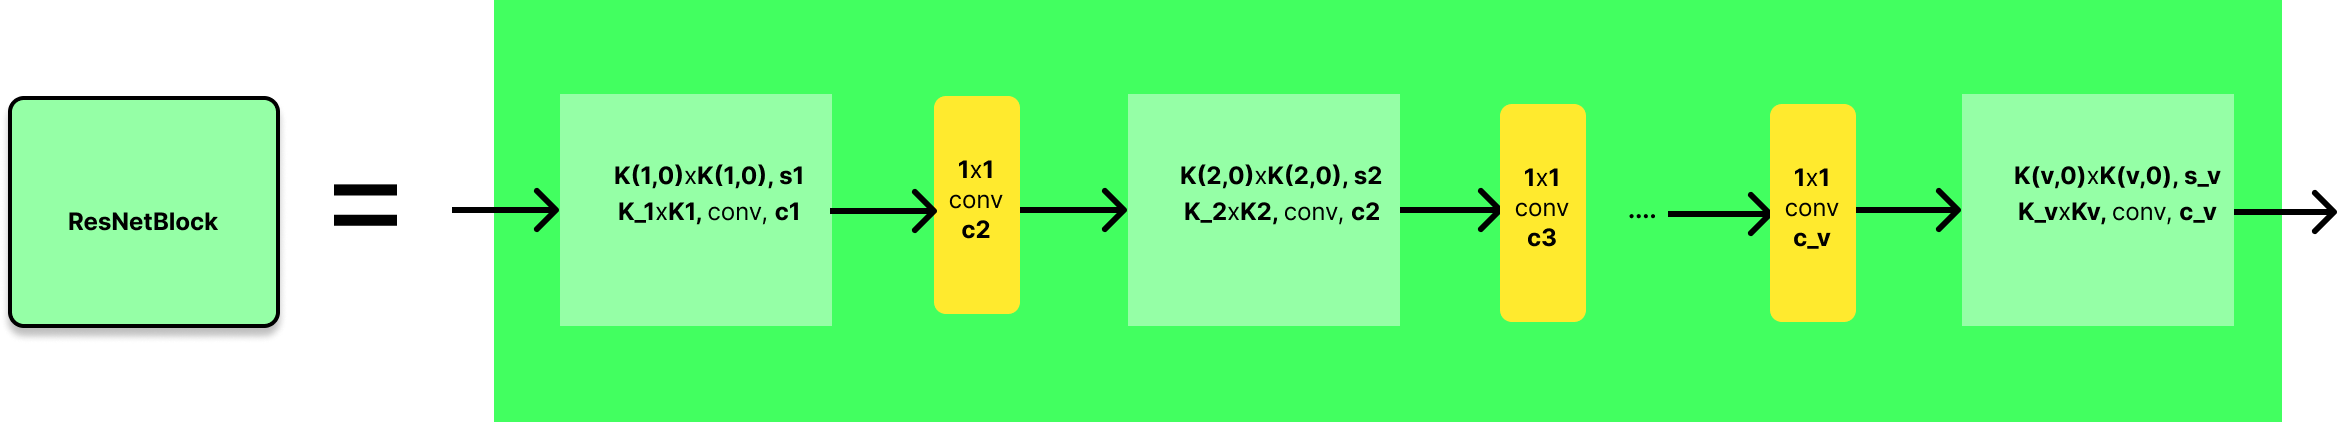
(Рисунок 2. ResNetBlock)

**ResNetEncoder** состоит из одного **ResNetBlock** и **FullyConnected** слоя (см. Рисунок 3. ResNetEncoder).
При этом размер **FullyConnected** состоит из матрицы $W \in \mathbb{R^{c_s*h_s*w_s×2*n\_latent}}$, где $n\_latent$ - размер скрытого пространства, $h_v$ - высота изображения с последнего слоя **ResNetBlock**, а $w_v$ - ширина изображения после прохождения последнего слоя **ResNetBlock**.

## Как работает Encoder
1. На вход подаётся изображение $X\in\mathbb{R}^{c_1×h_1×w_1}$ (в нашем случае $c_1=3$, $h_1 = 32$, $w_1 = 32$);
2. Далее оно проходит через $ResNetBlock$, после чего выдаётся некоторый тензор $X_v\in\mathbb{R}^{c_v×h_v×w_v}$;
3. После чего он преобразовывается в тензор $X_v'\in\mathbb{R}^{c_v*h_v*w_v}$;
4. Далее подаётся на вход в **FC** слой и получается вектор с параметрами среднего и дисперсии для нормального распределения некоторого латентного пространства $z'\in\mathbb{R}^{2*n\_latent}$.

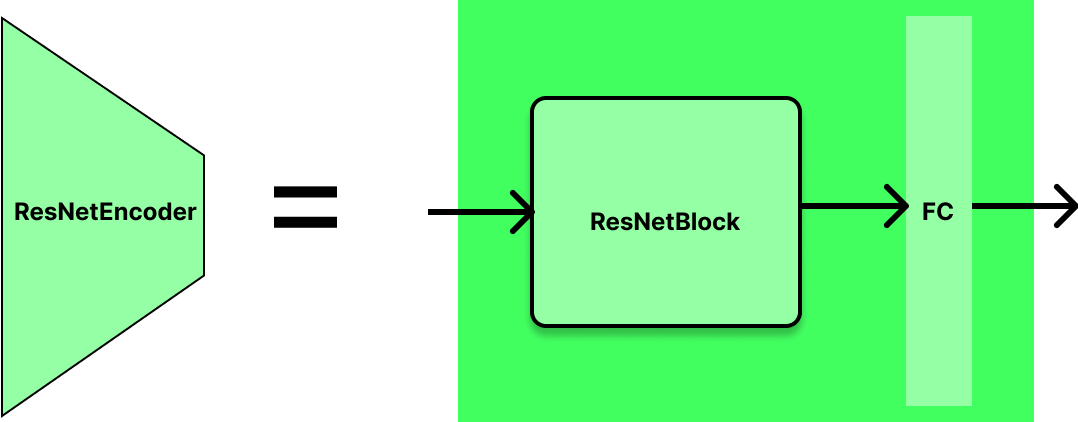
(Рисунок 3. ResNetEncoder)

**ResNetDecoder** имеет такую же архитектуру, за тем исключением, что свертки в **ConvBlock** являются **Transposed** и **Fully Connected** слой перемещается в самое начало для того, чтобы преобразовать вектор латентного пространства в тензор нужного размера для сверточного блока, но при этом с использованием (в моём случае) $stride=2$ в первой свертке **ConvBlockT** (см. Рисунок 4. ConvBlockT).
**Fully Connected** слой представляет из себя матрицу весов, которая имеет размер $W\in\mathbb{R}^{n\_latent×с_1*w_1*h_1}$

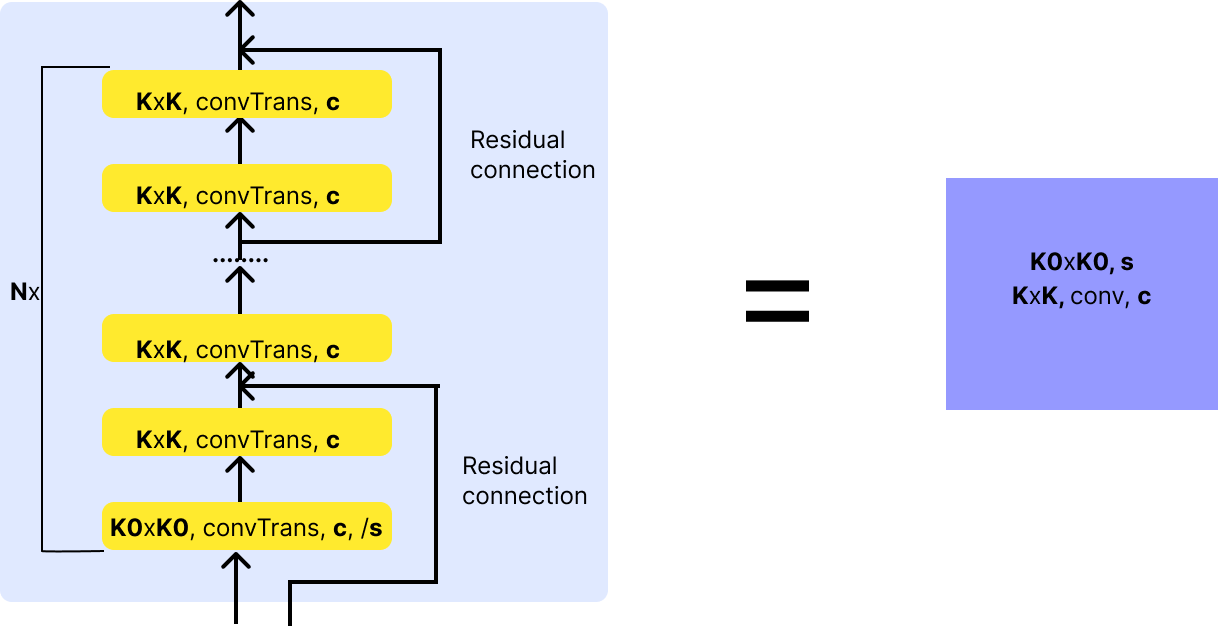
(Рисунок 4. ConvBlockT)

Далее, из таких нескольких **ConvBlockT** строится **ResNetT**-подобная архитектура (см. Рисунок 5. ResNetT), в нашем случае:
- **ConvBlockT** с **N** = 2, **K** = 3, **c** = 128, **s**=2;
- **ConvBlockT** с **N** = 2, **K** = 3, **c** = 64;
- **ConvBlockT** с **N** = 4, **K** = 3, **c** = 32;
- **ConvBlockT** с **N** = 4, **K** = 3, **c** = 3.


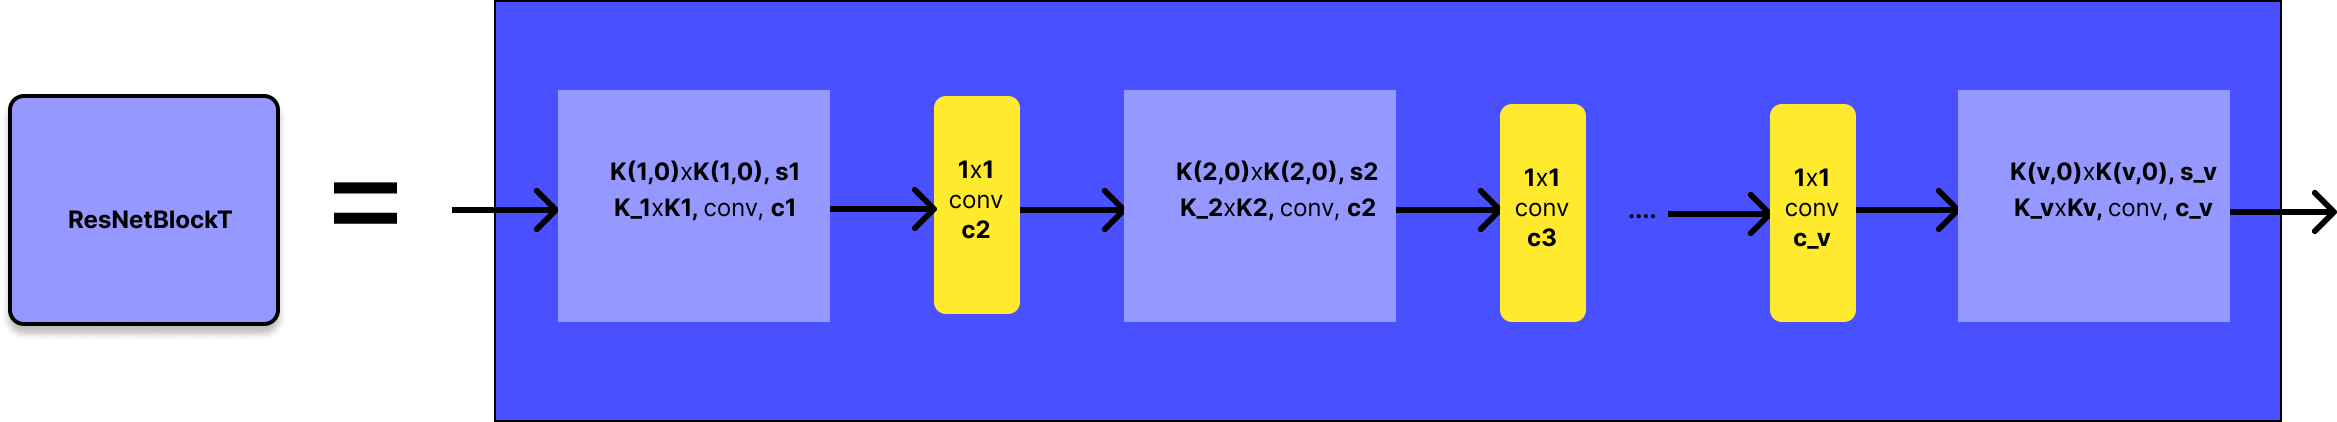
(Рисунок 5. ResNetT)

##Как работает декодер
1. Вектор $z\in\mathbb{R^{n\_latent}}$ (который при обучении мы получаем для изображения на выходе из энкодера, применя к нему reparametrization trick (см. Рисунок 7 VAE)) проходит через $FC$ слой, на выходе которого получается тензор $I'\in\mathbb{R}^{c_1×w_1×h_1}$
2. Далее тензор  $I'$ проходит через **ResNetBlock**, после чего на выходе получается некоторое изображение $I\in\mathbb{R}^{c_v×w_v×h_v}$ (в нашем случае $c_v = 3$, $w_v = 32$, $h_v = 32$)

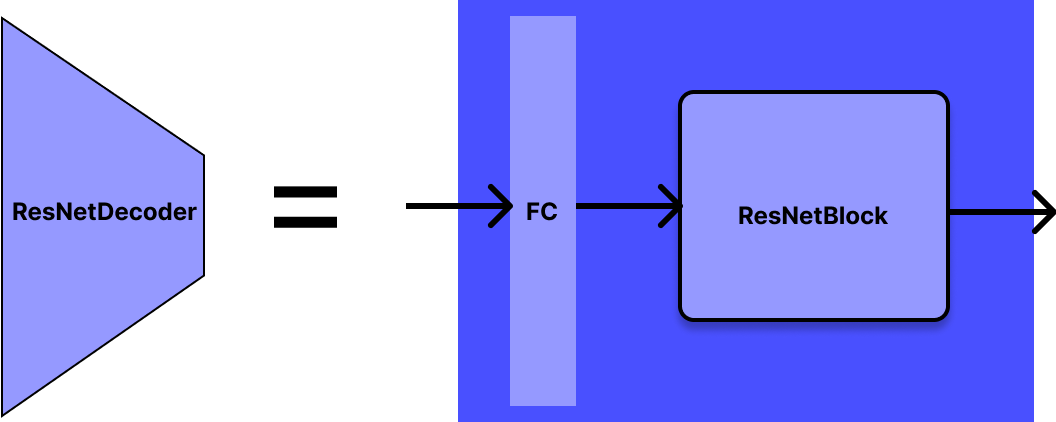
(Рисунок 6. ResNetDecoder)

На данной картинке просто показан процесс в общем, что моделируют **Encoder** и **Decoder**, и то, как происходит получение вектора $z$, с использованием параметром, которые выдаёт наш **ResNetEncoder** (к чему относится декодер и энкодер можно понять по цветам, значения которых поддерживались на протяжении рассказа :) )

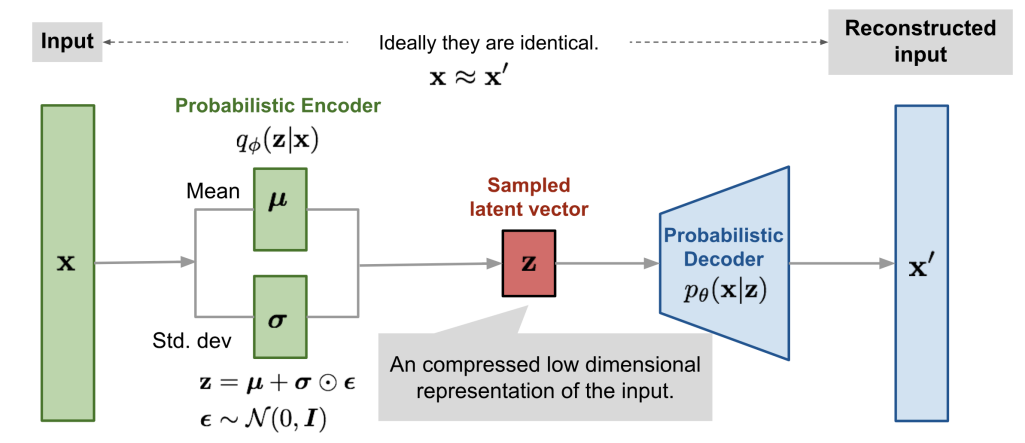
(Рисунок 7. VAE)

In [ ]:
REPO_NAME = "2022-2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

Cloning into '2022-2023-DGM-MIPT-course'...
remote: Enumerating objects: 527, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 527 (delta 14), reused 27 (delta 7), pack-reused 482
Receiving objects: 100% (527/527), 183.50 MiB | 15.81 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./2022-2023-DGM-MIPT-course/homeworks
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dgm-utils: filename=dgm_utils-0.1.0-py3-none-any.whl size=3617 sha256=619f5daaf6ecd

In [ ]:
!gdown --id 1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj
To: /content/cifar10.pkl
100% 185M/185M [00:04<00:00, 44.4MB/s]


In [ ]:
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu117

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/nightly/cu117


In [ ]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import visualize_2d_data, visualize_2d_samples
from dgm_utils import show_samples, visualize_images, load_pickle

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

USE_CUDA = torch.cuda.is_available()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1)), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standard normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    # ====
    # your code
    test = log_std_2 - log_std_1 + (torch.exp(2*log_std_1)+(mean_1 - mean_2)**2)/(2*torch.exp(2*log_std_2))-0.5
    return test
    # ====


def test_KL():
    assert np.isclose(get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)).numpy(), 200.2144, rtol=1e-3)
    assert np.isclose(get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)).numpy(), 1.50925, rtol=1e-3)
    assert np.allclose(get_normal_KL(torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))).numpy(), [49.2990, 1498.479], rtol=1e-3)


test_KL()

In [ ]:
def get_normal_nll(x, mean, log_std):
    """
        This function should return the negative log likelihood log p(x),
        where p(x) = Normal(x | mean, exp(log_std) ** 2).
        Note that we consider the case of diagonal covariance matrix.
    """
    # ====
    # your code
    test = -torch.distributions.normal.Normal(loc = mean,  scale = torch.exp(log_std)).log_prob(x)
    return test
    # ====


def test_NLL():
    assert np.isclose(get_normal_nll(torch.tensor(2), torch.tensor(2), torch.tensor(3)).numpy(), 3.9189, rtol=1e-3)
    assert np.isclose(get_normal_nll(torch.tensor(5), torch.tensor(-3), torch.tensor(6)).numpy(), 6.9191, rtol=1e-3)
    assert np.allclose(get_normal_nll(torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))).numpy(), np.array([3.9982, 5.9197]), rtol=1e-3)


test_NLL()

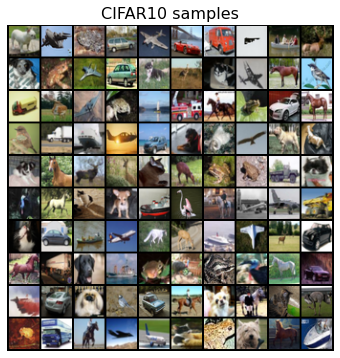

In [ ]:
train_data, test_data = load_pickle('/content/cifar10.pkl', flatten=False, binarize=False)
visualize_images(train_data, 'CIFAR10 samples')

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d

class ConvBlock(nn.Module):
  '''
  ConvBlock соответствующий тому, который описывался выше.
    in_channels - какое количество каналов будет иметь изображение на входе в ConvBlock
    out_channels - какое количество каналов будет иметь изображение на выходе из ConvBlock
    first_stride - какой страйд применяется при первой свёртке (в последующих не используется)
    n_conv - количество свёрток в ConvBlock (включая первую)
    kernel_size - размер ядра на всех свёртках в блоке
    relu_on_last - нужно ли убрать relu с последнего сверточного слоя в блоке
  '''
  def __init__(self, in_channels, out_channels, first_stride = 1, n_conv = 4, kernel_size = 3,
               relu_on_last = False) -> None:
      super().__init__()
      first_block = nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size,
                             stride = first_stride)
      blocks = nn.Sequential()

      for i in range(n_conv - 1):
        temp = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, padding = 1),
                            nn.BatchNorm2d(out_channels, affine = False),
                            nn.ReLU())
        blocks.append(temp)
      
      if not relu_on_last:
        blocks[-1] = blocks[-1][:-2] # удаляем ReLU и BatchNorm в последнем элементе последовательности

      self.first_block = first_block
      self.blocks = blocks
  '''

    Args:
      x - кортеж, который должен состоять из 2-х элементов:
        1. Входной тензор размера (bs, in_channels, h, w)
        2. Тензор с предыдущего сверточного блока, имеющий размеры (bs, out_channels, h', w')
          h' и w' от параметр свёрток (см. документацию torch.nn.Conv2d)
  '''
  def forward(self, x):
    x0, x_p = x
    x1 = self.first_block(x0)

    x2 = x1
    for s, module in enumerate(self.blocks, start = 1):
      x2 =  module(x2)
      if s % 2 == 0:
        x2 = x2 + x_p
        x_p = x2
    
    return x2



In [ ]:
def test_conv_block():
  bs, c, h, w,  = 8, 3, 32, 32
  out_c =  128
  input = torch.zeros((bs, c, h, w))
  x_p = torch.zeros((bs, out_c, h - 2, w - 2))
  module = ConvBlock(3, out_c)
  
  with torch.no_grad():
    output = module((input, x_p))
  
  assert output.shape == (bs, out_c, h-2, w-2)

test_conv_block()


In [ ]:
class ResNet(nn.Module):
  '''
  Класс ResNet, который соответствует объекту ResNetBlock в рассказе выше.
    input_shape - кортеж с размерностью первого входного изображения, который должен иметь следующие размеры (c, h, w)
  '''
  def __init__(self, input_shape) -> None:
     super().__init__()
     #conv блоки
     self.block_1 = ConvBlock(input_shape[0], out_channels=32, n_conv = 2)# (30, 30)
     self.block_2 = ConvBlock(32, out_channels=64, n_conv = 2)#(28,28)
     self.block_3 = ConvBlock(64, out_channels=128, n_conv = 4)#(26,26)
     self.block_4 = ConvBlock(128, out_channels=256, n_conv = 4)#(24,24)

    #residual connection для соединения размеров тензоров передаваемых между блоками
     self.res_1 = nn.Conv2d(input_shape[0], out_channels = 32, kernel_size = 3)
     self.res_2 = nn.Conv2d(32, out_channels = 64, kernel_size = 3)
     self.res_3 = nn.Conv2d(64, out_channels = 128, kernel_size = 3)
     self.res_4 = nn.Conv2d(128, out_channels = 256, kernel_size = 3)

     self.n_last_features = 256*24**2
  '''
  
    Args: 
      x - тензор размера (bs, *input_shape)
    Return:
      тензор размера (bs, 256, 24, 24)
  '''
  def forward(self, x):
    x_res1 = self.res_1(x)
    x1 = self.block_1((x, x_res1))

    x_res2 = self.res_2(x1)
    x2 = self.block_2((x1, x_res2))

    x_res3 = self.res_3(x2)
    x3 = self.block_3((x2, x_res3))
    
    x_res4 = self.res_4(x3)
    x4 = self.block_4((x3, x_res4))

    return x4

In [ ]:
def test_ResNet():
  bs, c, h, w,  = 8, 3, 32, 32
  out_c =  256
  input = torch.zeros((bs, c, h, w))
  module = ResNet(input.shape[1:])
  
  with torch.no_grad():
    output = module(input)
  
  params_count = sum(p.numel() for p in module.parameters())
  print(params_count)
  
  assert output.shape == (bs, out_c, 24, 24)

test_ResNet()

3036000


In [ ]:
class ResNetEncoder(nn.Module):
  '''
    input_shape - кортеж с размерностью первого входного изображения, который должен иметь следующие размеры (c, h, w)
    n_latent - размерность вектора в скрытом пространстве, которое является целочисленным значением
  '''
  def __init__(self, input_shape, n_latent) -> None:
     super().__init__()
     self.input_shape = input_shape
     self.n_latent = n_latent

     self.resnet = ResNet(input_shape)
     self.fc = nn.Linear(self.resnet.n_last_features, out_features = 2*n_latent)

  '''
    Args:
      x - тензор, размеров (bs, *input_shape)
    Return:
      кортеж со тензерами значений средних и log среднеквадратичного отклонения.
      Тензера имеют размер (bs, n_latent)
  '''
  def forward(self, x):
    x_resnet = self.resnet(x)
    x_resnet = x_resnet.reshape((x.shape[0], -1))
    
    z = self.fc(x_resnet)
    mu_z = z[:, :self.n_latent]
    log_std_z = z[:, self.n_latent:]

    return mu_z, log_std_z


In [ ]:
def test_ResNetEncoder():
  bs, c, h, w,  = 8, 3, 32, 32
  n_latent = 512
  input = torch.zeros((bs, c, h, w))
  module = ResNetEncoder(input.shape, n_latent)
  
  with torch.no_grad():
    output = module(input)


  assert output[0].shape == (bs, n_latent)
  assert output[1].shape == (bs, n_latent)

test_ResNetEncoder()

In [ ]:
class ConvBlockT(nn.Module):
  '''
  ConvBlock соответствующий тому, который описывался выше.
    in_channels - какое количество каналов будет иметь изображение на входе в ConvBlock
    out_channels - какое количество каналов будет иметь изображение на выходе из ConvBlock
    first_stride - какой страйд применяется при первой свёртке (в последующих не используется)
    n_conv - количество свёрток в ConvBlock (включая первую)
    kernel_size - размер ядра на всех свёртках в блоке
    first_ks - размер kernel_size у первой свертки в блоке
    relu_on_last - нужно ли убрать relu с последнего сверточного слоя в блоке
  '''
  def __init__(self, in_channels, out_channels, stride = 2, n_conv = 4, kernel_size = 3, first_ks = 4,
               relu_on_last = False) -> None:
      super().__init__()
      first_block = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = first_ks, padding = 1,
                                       stride = stride)
      blocks = nn.Sequential()

      for i in range(n_conv - 1):
        temp = nn.Sequential(nn.ConvTranspose2d(out_channels, out_channels, kernel_size = kernel_size, padding = 1),
                             nn.BatchNorm2d(out_channels, affine = False),
                             nn.ReLU())
        blocks.append(temp)
      
      if not relu_on_last:
        blocks[-1] = blocks[-1][:-2]

      self.first_block = first_block
      self.blocks = blocks
  '''

    Args:
      x - кортеж, который должен состоять из 2-х элементов:
        1. Входной тензор размера (bs, in_channels, h, w)
        2. Тензор с предыдущего сверточного блока, имеющий размеры (bs, out_channels, h', w')
          h' и w' от параметр свёрток (см. документацию torch.nn.ConvTranspose2d)
  '''
  def forward(self, x):
    x0, x_p = x
    x1 = self.first_block(x0)

    x2 = x1
    for s, module in enumerate(self.blocks, start = 1):
      x2 =  module(x2)
      if s % 2 == 0:
        x2 = x2 + x_p
        x_p = x2
    
    return x2

In [ ]:
def test_convT_block():
  bs, c, h, w,  = 8, 128, 4, 4
  out_c =  256
  input = torch.zeros((bs, c, h, w))
  x_p = torch.zeros((bs, out_c, h*2, w*2))
  module = ConvBlockT(c, out_c)
  
  with torch.no_grad():
    output = module((input, x_p))
  assert output.shape == x_p.shape

test_convT_block()


In [ ]:
class ResNetT(nn.Module):
  '''
  Класс ResNetT, который соответствует объекту ResNetBlockT в рассказе выше.
    input_shape - кортеж с размерностью первого входного изображения, который должен иметь следующие размеры (c, h, w)
  '''
  def __init__(self, input_shape) -> None:
     super().__init__()
     self.block_1 = ConvBlockT(input_shape[0], out_channels=128, n_conv = 2)
     self.block_2 = ConvBlockT(128, out_channels=64, n_conv = 2)#(28,28)
     self.block_3 = ConvBlockT(64, out_channels=32, n_conv = 4)#(26,26)
     self.block_4 = ConvBlockT(32, out_channels=3, n_conv = 4, stride = 1, kernel_size = 3, first_ks = 3)#(24,24)

     self.res_1 = nn.ConvTranspose2d(input_shape[0], out_channels = 128, kernel_size = 4, stride = 2)
     self.res_2 = nn.ConvTranspose2d(128, out_channels = 64, kernel_size = 4, stride = 2)
     self.res_3 = nn.ConvTranspose2d(64, out_channels = 32, kernel_size = 4, stride = 2, padding = 1)
     self.res_4 = nn.ConvTranspose2d(32, out_channels = 3, kernel_size = 3, stride = 1, padding = 1)

     self.n_last_features = 256*24**2
  '''
  
    Args: 
      x - тензор размера (bs, *input_shape)
    Return:
      тензор размера (bs, 3, 32, 32)
  '''
  def forward(self, x):
    x_res1 = self.res_1(x)
    x1 = self.block_1((x, x_res1))

    x_res2 = self.res_2(x1)
    x2 = self.block_2((x1, x_res2))

    x_res3 = self.res_3(x2)
    x3 = self.block_3((x2, x_res3))
    
    x_res4 = self.res_4(x3)
    x4 = self.block_4((x3, x_res4))

    return x4

In [ ]:
def test_ResNet():
  bs, c, h, w,  = 8, 128, 4, 4
  out_c =  3
  input = torch.zeros((bs, c, h, w))
  module = ResNetT(input.shape[1:])
  
  with torch.no_grad():
    output = module(input)
  print(output.shape)

  assert output.shape == (bs, out_c, 32, 32)

test_ResNet()

torch.Size([8, 3, 32, 32])


In [ ]:
class ResNetDecoder(nn.Module):
  '''
    output_shape - кортеж с размерностью изображения, которое предполагается восстановить, который должен иметь следующие размеры (c, h, w)
    n_latent - размерность вектора в скрытом пространстве, которое является целочисленным значением
  '''
  def __init__(self, n_latent, output_shape) -> None:
     super().__init__()
     self.output_shape = output_shape
     self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)

     self.resnetT = ResNetT(self.base_size)

     self.fc = nn.Linear(n_latent, np.prod(self.base_size))

  def forward(self, z):
        output_fc = self.fc(z)
        output_resh = output_fc.reshape((z.shape[0], *self.base_size))
        out = self.resnetT(output_resh)
        return out


In [ ]:
def test_ResNetDecoder():
  n_latent = 2
  bs = 8
  input_shape = (3, 32, 32)
  input = torch.zeros((bs, n_latent))
  decoder = ResNetDecoder(n_latent, input_shape)
  with torch.no_grad():
    output = decoder(input)

  assert output.shape  == (bs, *input_shape)

test_ResNetDecoder()

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, input_shape, n_latent, beta=1):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta
        # ====
        # your code
        # define encoder with input size input_shape and output dim n_latent
        # define decoder with input dim n_latent and output size input_shape
        self.encoder = ResNetEncoder(input_shape, n_latent)
        self.decoder = ResNetDecoder(n_latent, input_shape)
        
        # ====

    def prior(self, n, use_cuda=True):
        # ====
        # your code
        # return n samples from prior distribution (we use standart normal for prior)
        z = torch.normal(mean = torch.zeros((1, n)), std = torch.ones((1, n)))
        # ====
        if use_cuda:
            z = z.cuda()
        return z # (batch_size, channels, height, widht)

    def forward(self, x):
        # ====
        # your code
        # 1) apply encoder to get mu_z, log_std_z
        # 2) apply reparametrization trick (use self.prior)
        # 3) apply decoder to get mu_x (which corresponds to reconstructed x)
        mu_z, log_std_z = self.encoder(x)
        z = mu_z + torch.exp(log_std_z)*self.prior(self.n_latent)
        x_recon = self.decoder(z)
        # ====
        return mu_z, log_std_z, x_recon
        
    def loss(self, x):
        # ====
        # your code
        # 1) make forward step to get mu_z, log_std_z, x_recon
        # 2) calculate recon_loss (use get_normal_nll)
        # 3) calcucalte kl_loss (use get_normal_KL)
        mu_z, log_std_z, recon_x = self.forward(x)
        log_std_x = torch.zeros(x.shape).to(x.device)

        kl_loss = get_normal_KL(mu_z, log_std_z).sum() / x.shape[0]
        recon_loss = get_normal_nll(x, recon_x, log_std_x).sum() / x.shape[0]
        
        # ==== 
        return {
            'elbo_loss': recon_loss + self.beta * kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n):
        with torch.no_grad():
            # ====
            # your code
            # 1) generate prior samples
            # 2) apply decoder
            prior_samples = self.prior(self.n_latent*n).reshape(n, self.n_latent).to('cuda:0')
            x_recon = self.decoder(prior_samples)
            # ====
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

In [ ]:
def test_forward_Vae():
  n_latent = 128
  bs = 1
  input_shape = (3, 32, 32)
  input = torch.zeros((bs, *input_shape)).to('cuda:0')
  cVAE = ConvVAE(input_shape, n_latent).to('cuda:0')
  with torch.no_grad():
    _, _, output = cVAE(input)

  assert output.shape  == (bs, *input_shape)

def test_loss_Vae():
  n_latent = 2
  bs = 1
  input_shape = (3, 32, 32)
  input = torch.zeros((bs, *input_shape)).to('cuda:0')
  cVAE = ConvVAE(input_shape, n_latent).to('cuda:0')
  with torch.no_grad():
    cVAE.loss(input)

def test_samples_Vae():
  n_latent = 2
  n = 5
  input_shape = (3, 32, 32)
  cVAE = ConvVAE(input_shape, n_latent).to('cuda:0')
  with torch.no_grad():
    output = cVAE.sample(n)
  
  assert output.shape == (n, *input_shape)
  

test_forward_Vae()
test_loss_Vae()
test_samples_Vae()

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


  0%|          | 0/8 [00:00<?, ?it/s]

elbo_loss: 2970.8880
recon_loss: 2937.5954
kl_loss: 41.6158


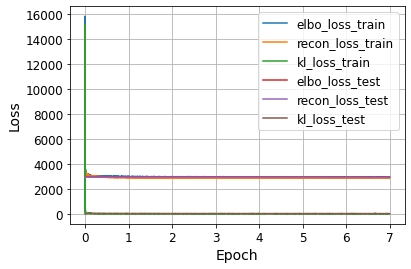

In [ ]:
# ====
# your code
# choose these parameters

BATCH_SIZE =  32 # any adequate value
EPOCHS = 8     # < 16
LR = 1e-4         # < 1e-3
N_LATENS = 256 # 128 < _ < 1024
BETA = 0.8 # 0.1 < _ < 10
# ====

# we center the data, because it helps the model to fit
centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = ConvVAE((3, 32, 32), N_LATENS, BETA)

train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    loss_key='elbo_loss', 
    use_tqdm=True, 
    use_cuda=USE_CUDA, 
)
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

In [ ]:
should_save = True

In [ ]:
PATH =  '/content/drive/MyDrive/ResNetVAE_Second'
if should_save:
    torch.save(model.state_dict(), PATH)

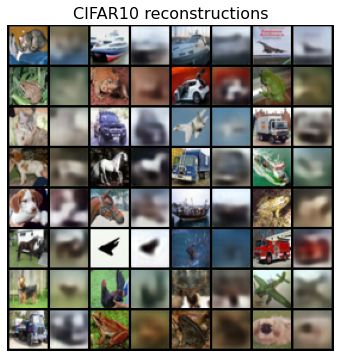

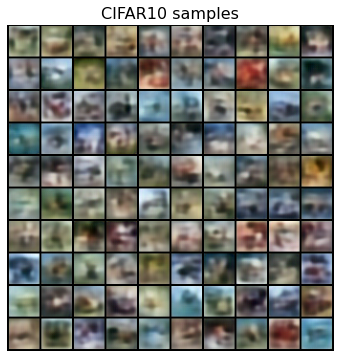

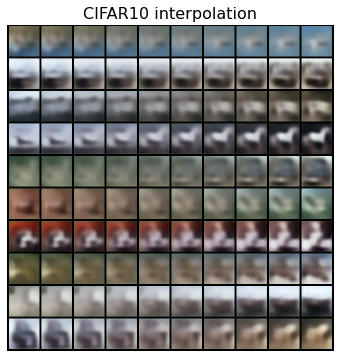

In [ ]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]

if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20].cuda()
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')
show_samples(samples, 'CIFAR10 samples')
show_samples(interps, 'CIFAR10 interpolation')